C:\Users\satto\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\satto\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Seed 1 완료 및 저장


C:\Users\satto\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Seed 2 완료 및 저장


C:\Users\satto\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Seed 3 완료 및 저장


C:\Users\satto\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Seed 4 완료 및 저장


✅ Seed 5 완료 및 저장


C:\Users\satto\AppData\Local\Temp\ipykernel_23640\211217771.py:160: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\satto\AppData\Local\Temp\ipykernel_23640\211217771.py:160: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\satto\AppData\Local\Temp\ipykernel_23640\211217771.py:160: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\satto\AppData\Local\Temp\ipykernel_23640\211217771.py:160: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\satto\AppData\Local\Temp\ipykernel_23640\211217771.py:160: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\satto\AppData\Local\Temp\ipykernel_23640\211217771.py:160: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing fr

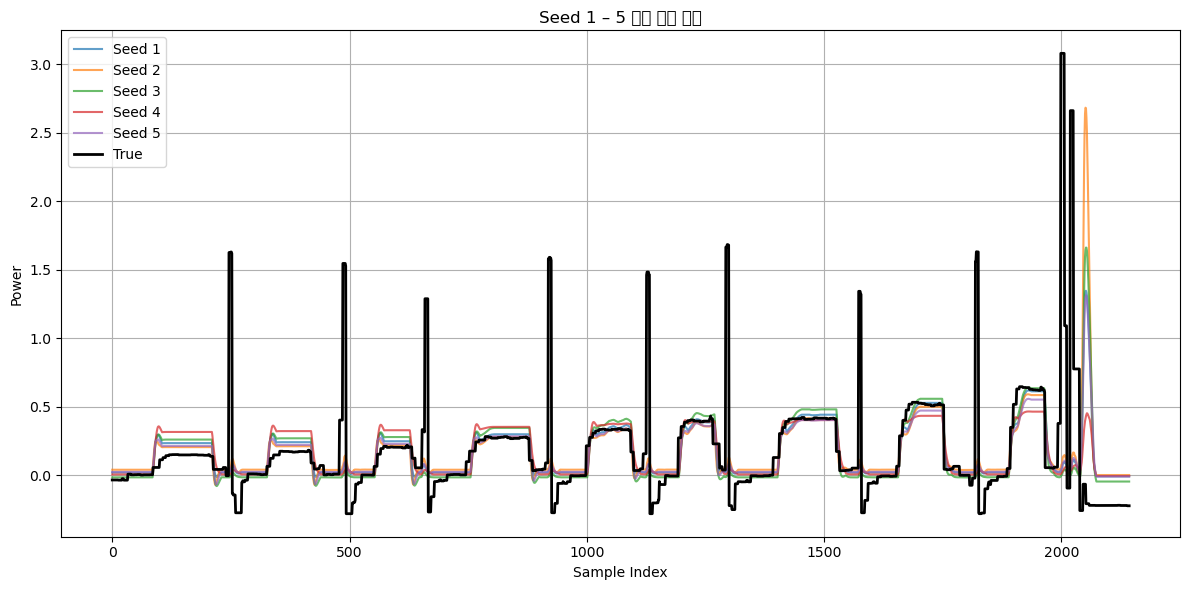

In [1]:
import os
import random
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# -------------------------------
# 📁 1. 경로 및 설정
# -------------------------------

# 🔽 [🟨 사용자 맞춤: 여기에 본인 경로 입력] 🔽
data_dir = r"D:\Machinelearning_and_programing"       # 데이터 폴더
save_dir = r"D:\Machinelearning_and_programing"    # 저장 폴더


train_path1 = os.path.join(data_dir, "matched_result_with_force_SM45C_10pi_flat.csv")
train_path2 = os.path.join(data_dir, "matched_result_with_force_SM45C_16pi_flat.csv")
train_path3 = os.path.join(data_dir, "matched_result_with_force_AL6061_16pi_Drill.csv")
test_path = os.path.join(data_dir, "matched_result_with_force_JIS_16pi_flat.csv")

model_dir = os.path.join(save_dir, "models")
scaler_dir = os.path.join(save_dir, "scalers")
result_dir = os.path.join(save_dir, "predictions")

os.makedirs(model_dir, exist_ok=True)
os.makedirs(scaler_dir, exist_ok=True)
os.makedirs(result_dir, exist_ok=True)

save_prefix = "lstm_energy_20250619"

features = ['cls', 'Force', 'feed_norm', 'is_cut_active', 'energy_proxy']
target = 'pwr'
SEQ_LEN = 20
LAG = 10
NUM_SEEDS = 5 # 반복학습 횟수
GROUP_SIZE = 5 # floting할 그림 수수

# -------------------------------
# ⚙️ 함수 정의
# -------------------------------
def add_features(df):
    df['clx_masked'] = 0.0
    df['cly_masked'] = 0.0
    df['clz_masked'] = df['clz']
    x_diff = df['X'].diff().abs()
    y_diff = df['Y'].diff().abs()
    df.loc[x_diff > 0, 'clx_masked'] = df['clx']
    df.loc[y_diff > 0, 'cly_masked'] = df['cly']
    df['is_cut_active'] = (df['Force'] > 0).astype(int)
    df['force_norm'] = np.linalg.norm(df[['clx', 'cly', 'clz']].values, axis=1)
    df['feed_norm'] = np.linalg.norm(df[['X', 'Y', 'Z']].diff().fillna(0).values, axis=1)
    df['energy_proxy'] = df['force_norm'] * df['feed_norm']
    return df

def create_sequences(X, y, seq_len=SEQ_LEN, lag=LAG):
    Xs, ys = [], []
    for i in range(len(X) - seq_len - lag):
        Xs.append(X[i:i + seq_len])
        ys.append(y[i + seq_len + lag])
    return np.array(Xs), np.array(ys)

# -------------------------------
# 📊 데이터 로딩 및 처리
# -------------------------------
df_train = add_features(pd.concat([
    pd.read_csv(train_path1),
    pd.read_csv(train_path2),
    pd.read_csv(train_path3)
], ignore_index=True))
df_test = add_features(pd.read_csv(test_path))

train_cut = df_train.dropna(subset=features + [target])
test_cut = df_test.dropna(subset=features + [target])

Q1 = train_cut[target].quantile(0.25)
Q3 = train_cut[target].quantile(0.75)
IQR = Q3 - Q1
train_cut = train_cut[(train_cut[target] >= Q1 - 1.5 * IQR) & (train_cut[target] <= Q3 + 1.5 * IQR)]

scaler_X = MinMaxScaler().fit(train_cut[features])
scaler_y = MinMaxScaler().fit(train_cut[[target]])

X_train = scaler_X.transform(train_cut[features])
y_train = scaler_y.transform(train_cut[[target]])
X_test = scaler_X.transform(test_cut[features])
y_test = scaler_y.transform(test_cut[[target]])

X_train_seq, y_train_seq = create_sequences(X_train, y_train)
X_test_seq, y_test_seq = create_sequences(X_test, y_test)
true_cut = scaler_y.inverse_transform(y_test[SEQ_LEN + LAG:]).flatten()

# -------------------------------
# 🧠 학습 및 예측 + 저장
# -------------------------------
pred_dict = {}
seeds = list(range(1, NUM_SEEDS + 1))

for seed in seeds:
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(SEQ_LEN, len(features))),
        LSTM(32),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(loss='huber', optimizer=Adam(learning_rate=0.001))
    model.fit(
        X_train_seq, y_train_seq,
        validation_split=0.2,
        epochs=30,
        batch_size=32,
        verbose=0,
        callbacks=[EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)]
    )

    pred = scaler_y.inverse_transform(model.predict(X_test_seq, verbose=0)).flatten()
    pred_dict[seed] = pred

    model.save(os.path.join(model_dir, f"{save_prefix}_seed_{seed}.h5"))
    joblib.dump(scaler_X, os.path.join(scaler_dir, f"scaler_X_seed_{seed}.pkl"))
    joblib.dump(scaler_y, os.path.join(scaler_dir, f"scaler_y_seed_{seed}.pkl"))

    result_df = test_cut.iloc[SEQ_LEN + LAG:].copy()
    result_df['True_pwr'] = true_cut
    result_df['Predicted_pwr'] = pred
    result_df[['True_pwr', 'Predicted_pwr']].to_csv(
        os.path.join(result_dir, f"{save_prefix}_predictions_seed_{seed}.csv"), index=False
    )
    print(f"✅ Seed {seed} 완료 및 저장")

# -------------------------------
# 📈 예측 결과 시각화
# -------------------------------
num_groups = (NUM_SEEDS + GROUP_SIZE - 1) // GROUP_SIZE

for g in range(num_groups):
    start = g * GROUP_SIZE
    end = min(start + GROUP_SIZE, NUM_SEEDS)
    plt.figure(figsize=(12, 6))
    for j in range(start, end):
        seed = seeds[j]
        plt.plot(pred_dict[seed], label=f'Seed {seed}', alpha=0.7)
    plt.plot(true_cut, label='True', color='black', linewidth=2)
    plt.title(f"Seed {seeds[start]} – {seeds[end - 1]} 예측 결과 비교")
    plt.xlabel("Sample Index")
    plt.ylabel("Power")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
